In [37]:
import texfig
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd
from t3f import initializers
from t3f import approximate
from scipy import optimize 
from nilearn.masking import compute_background_mask
from nilearn.masking import compute_epi_mask
from collections import OrderedDict
import pandas as pd
from scipy import stats
from nilearn.image import math_img
from t3f import initializers
import numpy.testing as nps
from dipy.sims.voxel import add_noise
import nibabel as nib
import noise_util as nu
import draw_utils as dr
import os
from nipype.algorithms import confounds as nac
import os.path as op
import spike_detection as sp
from nilearn.signal import clean
from scipy.stats import zscore

In [2]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)
ground_truth = np.array(x_true_org.get_data()).astype('float32')

Subject Path: /work/pl/sch/analysis/data/COBRE001/subject1.nii


In [4]:
dvars = nac.ComputeDVARS()

In [33]:
dvars.inputs.in_file = subject_scan_path
dvars.inputs.in_mask = 'epi_mask.nii'
dvars.inputs.save_all = True
dvars.inputs.save_plot = True
dvars.inputs.figformat = 'pdf'
dvars.run()

TraitError: Cannot set the undefined 'tr' attribute of a 'ComputeDVARSInputSpec' object.

In [6]:
comp_corr = nac.CompCor()
comp_corr.inputs.realigned_file = subject_scan_path
comp_corr.run()

In [19]:
fname, ext = op.splitext(op.basename(subject_scan_path))
out_suffix = fname + ".nii.gz"
tsnr_file = "tsnr_" + out_suffix
mean_file = "mean_" + out_suffix
stddev_file = "stddev_" + out_suffix
tsnr = nac.TSNR()
tsnr.inputs.in_file = subject_scan_path
tsnr.inputs.tsnr_file = tsnr_file
tsnr.inputs.mean_file = mean_file
tsnr.inputs.stddev_file = stddev_file
tsnr.run()

In [15]:
tsnr_file

'tsnr_/apps/git/python/tt-denois/src/subject1.nii.gz'

In [17]:
fname

'subject1'

In [27]:
folder = "/work/project/cmsc655/subject_artifacts"

In [28]:
n_spikes, out_spikes, out_fft, spikes_list = sp.slice_wise_fft(subject_scan_path, folder, spike_thres=4.)

((39, 18), 12)
((64, 18), 14)
((125, 6), 56)
((125, 7), 364)
((125, 8), 284)
((129, 15), 20)


In [29]:
out_spikes

'/work/project/cmsc655/subject_artifacts/subject_spikes.tsv'

In [30]:
from scipy.stats import zscore

In [31]:
zcarpet = np.nan_to_num(zscore(ground_truth, axis=-1))

In [32]:
zcarpet.shape

(53, 63, 46, 144)

In [35]:

slise_wize_voxel_intensity = zcarpet.mean(axis=0)**5

In [37]:
slise_wize_voxel_intensity.ravel().tolist()

[-0.00011296216689515859,
 0.11921834945678711,
 0.0011958095710724592,
 -8.96502569958102e-06,
 -0.005235051736235619,
 -0.0006720487726852298,
 0.019319891929626465,
 -2.406526675713394e-07,
 -0.027383696287870407,
 0.002084160689264536,
 -3.674932486319449e-06,
 -0.005787764210253954,
 -0.07003605365753174,
 4.884812554450946e-09,
 -0.06651164591312408,
 -0.0039671375416219234,
 -0.10751093924045563,
 -6.176539318403229e-05,
 5.828112080052961e-06,
 0.001229595043696463,
 -0.013425949960947037,
 1.8203479612566298e-06,
 -0.04893312230706215,
 -4.4748753680323716e-07,
 -0.005417441949248314,
 -1.872731331786781e-06,
 -0.005358964670449495,
 -7.448158157785656e-06,
 0.0007750532240606844,
 -0.0032118065282702446,
 9.906808600135264e-07,
 -0.00028159632347524166,
 -3.7033103581052274e-05,
 -2.651403199099324e-14,
 -0.00019777494890149683,
 -0.0056707183830440044,
 -9.751763485610354e-08,
 -6.685762491542846e-05,
 0.010147279128432274,
 1.993051773752086e-05,
 -0.002344040432944894,
 3.

In [4]:
image_folder_path = "/work/scratch/alternate_minimation/richian1/run_2018-12-07_03_54_42/d4/richian/scans/final/mr/2000"
sparse_path = os.path.join(image_folder_path, "x_sparse_hat_img_2000.nii")
guass_path = os.path.join(image_folder_path, "x_guass_hat_img_2000.nii")
low_rank_path = os.path.join(image_folder_path, "x_low_rank_hat_img_2000.nii")
noisy_path = os.path.join(image_folder_path, "x_noisy_img_2000.nii")

In [13]:
from nilearn._utils import check_niimg_4d
from nilearn._utils.niimg import _safe_get_data

In [25]:
sparse_img = mt.read_image_abs_path(sparse_path)
guass_img = mt.read_image_abs_path(guass_path)
low_rank_img = mt.read_image_abs_path(low_rank_path)
noisy_img = mt.read_image_abs_path(noisy_path)

In [68]:
img_nii = check_niimg_4d(low_rank_img, dtype='auto',)
low_rank_data = _safe_get_data(img_nii, ensure_finite=True)

v = (None, None)
ntsteps = low_rank_img.shape[-1]
data = low_rank_data.reshape(-1, ntsteps)
t_dec = 1 + low_rank_data.shape[1] 
if t_dec:
        data = data[:, ::t_dec]

In [22]:
data

array([[2.5785454e-05, 2.6593920e-05, 2.4519279e-05],
       [2.4470641e-05, 2.5656609e-05, 2.4040410e-05],
       [2.4970390e-05, 2.5039471e-05, 2.5073708e-05],
       ...,
       [2.4020081e-05, 2.4347562e-05, 2.3637558e-05],
       [2.4249186e-05, 2.3759305e-05, 2.3667773e-05],
       [2.2176553e-05, 2.3927652e-05, 2.3434215e-05]], dtype=float32)

In [20]:
print low_rank_img

<class 'nibabel.nifti1.Nifti1Image'>
data shape (53, 63, 46, 144)
affine: 
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : 
dim_info        : 0
dim             : [  4  53  63  46 144   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : unknown
sform_code      : aligned


In [48]:
data_clean = np.nan_to_num(zscore(data, axis=-1))

In [69]:
data = clean(data.T, t_r=1).T
v = (-2, 2)

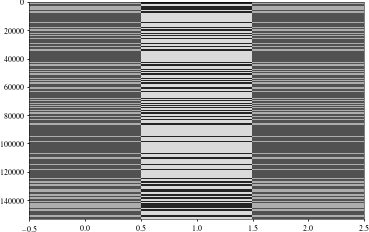

In [70]:
plt.imshow(data, interpolation='nearest', aspect='auto', cmap='gray',
               vmin=v[0], vmax=v[1])

In [50]:
img_nii = check_niimg_4d(noisy_img, dtype='auto',)
noisy_rank_data = _safe_get_data(img_nii, ensure_finite=True)

v = (None, None)
ntsteps = low_rank_img.shape[-1]
noisy_data = noisy_rank_data.reshape(-1, ntsteps)
t_dec = 1 + noisy_data.shape[1] 
if t_dec:
        noisy_data = noisy_data[:, ::t_dec]

In [38]:
zcarpet_noisy = np.nan_to_num(zscore(noisy_data, axis=-1))

/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:2246: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


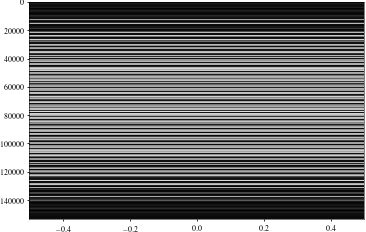

In [53]:
plt.imshow(noisy_data, aspect='auto', cmap='gray')

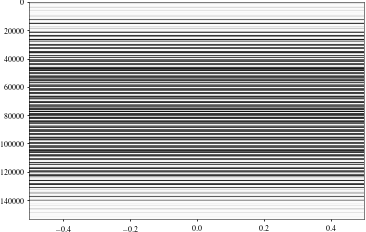

In [71]:
img_nii = check_niimg_4d(sparse_img, dtype='auto',)
sparce_rank_data = _safe_get_data(img_nii, ensure_finite=True)

v = (None, None)
ntsteps = low_rank_img.shape[-1]
sparce_rank_data = sparce_rank_data.reshape(-1, ntsteps)
t_dec = 1 + sparce_rank_data.shape[1] 
if t_dec:
        sparce_rank_data = sparce_rank_data[:, ::t_dec]
        
        
#zcarpet_sparce = np.nan_to_num(zscore(noisy_data, axis=-1))
plt.imshow(sparce_rank_data, interpolation='nearest', aspect='auto', cmap='gray',
               vmin=v[0], vmax=v[1])


In [74]:
sparce_rank_data = clean(sparce_rank_data.T, t_r=1).T
v = (-2, 2)

/Users/cn101458/Library/Python/2.7/lib/python/site-packages/nilearn/signal.py:141: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/cn101458/Library/Python/2.7/lib/python/site-packages/nilearn/signal.py:53: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


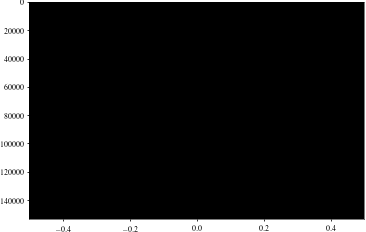

In [85]:
plt.imshow(sparce_rank_data, interpolation='nearest', aspect='auto', cmap='gray',
               vmin=v[0], vmax=v[1])

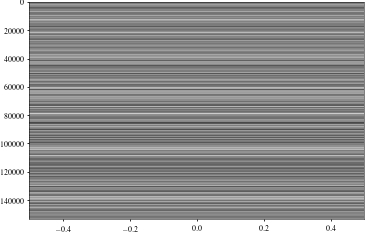

In [80]:
img_nii = check_niimg_4d(guass_img, dtype='auto',)
guass_data = _safe_get_data(img_nii, ensure_finite=True)

v = (None, None)
ntsteps = guass_data.shape[-1]
guass_data = guass_data.reshape(-1, ntsteps)
t_dec = 1 + guass_data.shape[1] 
if t_dec:
        guass_data = guass_data[:, ::t_dec]
        
        
#zcarpet_sparce = np.nan_to_num(zscore(noisy_data, axis=-1))
plt.imshow(guass_data, interpolation='nearest', aspect='auto', cmap='gray',
               vmin=v[0], vmax=v[1])

In [79]:
guass_data = clean(guass_data.T, t_r=1).T
v = (-2, 2)

/Users/cn101458/Library/Python/2.7/lib/python/site-packages/nilearn/signal.py:141: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/Users/cn101458/Library/Python/2.7/lib/python/site-packages/nilearn/signal.py:53: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


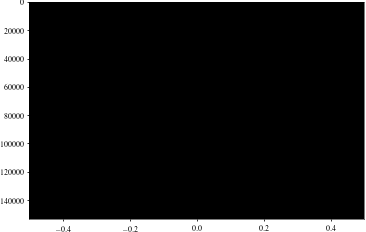

In [83]:
#zcarpet_sparce = np.nan_to_num(zscore(noisy_data, axis=-1))
plt.imshow(guass_data, interpolation='nearest', aspect='auto', cmap='gray',
               vmin=v[0], vmax=v[1])

In [82]:
guass_data = np.nan_to_num(zscore(guass_data, axis=-1))

In [84]:
sparce_rank_data = np.nan_to_num(zscore(sparce_rank_data, axis=-1))